In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
# from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
import glob
import os

In [ ]:
!rm -rf ventmap waveforms labels *.csv
!unzip ventmap.zip 
!unzip waveforms.zip 
!unzip labels.zip 

Archive:  ventmap.zip
   creating: ventmap/
  inflating: ventmap/add_timestamp_to_file.py  
  inflating: ventmap/anonymize_datatimes.py  
  inflating: ventmap/breath_meta.py  
  inflating: ventmap/clear_null_bytes.py  
  inflating: ventmap/constants.py    
  inflating: ventmap/convert_3_col_file_to_2_col.py  
  inflating: ventmap/cut_breath_section.py  
  inflating: ventmap/detection.py    
  inflating: ventmap/preprocess_all_files.py  
  inflating: ventmap/raw_utils.py    
  inflating: ventmap/rounding_rules.py  
  inflating: ventmap/SAM.py          
 extracting: ventmap/__init__.py     
Archive:  waveforms.zip
   creating: waveforms/
   creating: waveforms/1/
   creating: waveforms/10/
  inflating: waveforms/10/1008cut.csv  
   creating: waveforms/11/
  inflating: waveforms/11/1009cut.csv  
   creating: waveforms/12/
  inflating: waveforms/12/1010_1cut.csv  
   creating: waveforms/13/
  inflating: waveforms/13/1010_2cut.csv  
   creating: waveforms/14/
  inflating: waveforms/14/1011c

## Get the wave form data of pressure and flow

In [ ]:
from io import open
from ventmap.raw_utils import extract_raw

# sample points
flows = []
pressures = []
# breaths
flow_list = []
pressure_list = []

for (dir_path, dir_names, file_names) in os.walk('./waveforms'):
    for file in file_names:
        csv_path = os.path.join(dir_path, file)
        print(csv_path)
        generator = extract_raw(open(csv_path), False)
        for breath in generator:
            # breath data is output in dictionary format
            flow, pressure = breath['flow'], breath['pressure']
            flows += flow
            pressures += pressure
            flow_list.append(flow)
            pressure_list.append(pressure)
print(len(flow_list))

./waveforms/29/1026cut.csv
./waveforms/22/1019cut.csv
./waveforms/25/1022cut.csv
./waveforms/37/1034cut.csv
./waveforms/10/1008cut.csv
./waveforms/19/1016cut.csv
./waveforms/6/1004cut.csv
./waveforms/30/1027cut.csv
./waveforms/15/1012cut.csv
./waveforms/34/1031cut.csv
./waveforms/2/1001_1cut.csv
./waveforms/11/1009cut.csv
./waveforms/3/1001_2cut.csv
./waveforms/8/1006cut.csv
./waveforms/32/1029cut.csv
./waveforms/26/1023cut.csv
./waveforms/36/1033cut.csv
./waveforms/13/1010_2cut.csv
./waveforms/27/1024cut.csv
./waveforms/1/1000cut.csv
./waveforms/35/1032cut.csv
./waveforms/18/1015cut.csv
./waveforms/21/1018cut.csv
./waveforms/9/1007cut.csv
./waveforms/31/1028cut.csv
./waveforms/14/1011cut.csv
./waveforms/5/1003cut.csv
./waveforms/7/1005cut.csv
./waveforms/28/1025cut.csv
./waveforms/16/1013cut.csv
./waveforms/4/1002cut.csv
./waveforms/24/1021cut.csv
./waveforms/20/1017cut.csv
./waveforms/33/1030cut.csv
./waveforms/12/1010_1cut.csv
./waveforms/17/1014cut.csv
./waveforms/23/1020cut.csv
97

In [ ]:
# max and min length among all the breaths
# max_len = 0
# min_len = 100000
# for pressure in pressure_list:
#     if len(pressure) > max_len:
#         max_len = len(pressure)
#     if len(pressure) < min_len:
#         min_len = len(pressure)
# print(max_len, min_len)
len_list = []
for pressure in pressure_list:
    len_list.append(len(pressure))
len_cut = int(np.percentile(len_list, 90))
print(len_cut)

215


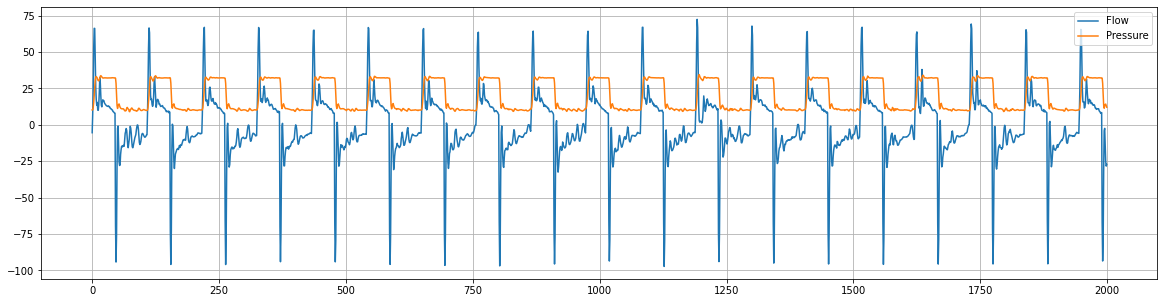

In [ ]:
# sample data plot 
plt.figure(figsize=(20, 5))
plt.plot(flows[:2000], label='Flow')
plt.plot(pressures[:2000], label='Pressure')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Get the Label data

In [ ]:
label_list = []
for (dir_path, dir_names, file_names) in os.walk('./labels'):
    for file in file_names:
        csv_path = os.path.join(dir_path, file)
        print(csv_path)
        df = pd.read_csv(csv_path)
        df_filter = df[['dbl', 'mt', 'bs', 'co', 'su']]
        label_list.append(df_filter)
df_total = pd.concat(label_list, axis=0, ignore_index=True)
# df_total.describe()
df_total.to_csv("label_total.csv")
notation = df_total.to_numpy()

./labels/29/1026_3510to3810_goldstd_dbl_bs_cosumtvd.csv
./labels/22/1019_1000to1300_goldstd_dbl_bs_cosumtvd.csv
./labels/25/1022_1to301_goldstd_dbl_bs_cosumtvd.csv
./labels/37/1034_18450to18750_goldstd_dbl_bs_cosumtvd.csv
./labels/10/1008goldstd.csv
./labels/19/1016goldstd.csv
./labels/6/1004goldstd.csv
./labels/30/1027_2070to2371_goldstd_dbl_bs_cosumtvd.csv
./labels/15/1012goldstd.csv
./labels/34/1031_7300to7600_goldstd_dbl_bs_cosumtvd.csv
./labels/2/1001_1goldstd.csv
./labels/11/1009goldstd.csv
./labels/3/1001_2goldstd.csv
./labels/8/1006goldstd.csv
./labels/32/1029_13300to13600_goldstd_dbl_bs_cosumtvd.csv
./labels/26/1023_2000to2300_goldstd_dbl_bs_cosumtvd.csv
./labels/36/1033_100to400_goldstd_dbl_bs_cosumtvd.csv
./labels/13/1010_2goldstd.csv
./labels/27/1024_251to301_goldstd_dbl_bs_cosumtvd.csv
./labels/1/1000goldstd.csv
./labels/35/1032_300to600_goldstd_dbl_bs_cosumtvd.csv
./labels/18/1015goldstd.csv
./labels/21/1018_1388to1689_goldstd_dbl_bs_cosumtvd.csv
./labels/9/1007goldstd.cs

In [ ]:
# check if the pva type is unique in each row
test = (df_total == 0).sum(axis=1) < 4
count = 0
for index, value in test.items():
    if value == True:
        count += 1
print(count)

9


In [ ]:
def check_notation(i):
    if notation[i][0] == 1:
        label = 1 #"dbl"
    elif notation[i][1] == 1:
        label = 2 #"mt"
    elif notation[i][2] == 1:
        label = 3 #"bs"
    elif notation[i][3] == 1:
        label = 4 #"co"
    elif notation[i][4] == 1:
        label = 5 #"su"
    else:
        label = 0 #"normal"
    return label

In [ ]:
signals = [] 
anns = []

for i, pressure in enumerate(pressure_list):
    flow = flow_list[i]
    if len(pressure) < len_cut:
        pressure_ext = np.concatenate([pressure, np.zeros(len_cut-len(pressure))])
        pressure_ext = pressure_ext.tolist()
        flow_ext = np.concatenate([flow, np.zeros(len_cut-len(flow))])
        flow_ext = flow_ext.tolist()
        pressure_flow = pressure_ext + flow_ext
        signals.append(pressure_flow)
        label = check_notation(i)
        anns.append(label)
    else:
        pressure_ext = pressure[:len_cut]
        flow_ext = flow[:len_cut]
        pressure_flow = pressure_ext + flow_ext
        signals.append(pressure_flow)
        label = check_notation(i)
        anns.append(label)

In [ ]:
signals_csv = np.matrix(signals)
anns_csv = np.matrix(anns)
print(signals_csv.shape, anns_csv.shape)

comb_sig_ann = np.concatenate((signals_csv, anns_csv.T), axis=1)
df = pd.DataFrame(comb_sig_ann)
df.to_csv('pattern.csv', index=False)

(9719, 430) (1, 9719)


In [ ]:
df = pd.read_csv("pattern.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
0,10.24,10.39,11.84,15.50,20.06,25.92,30.96,32.85,33.18,32.70,32.17,30.98,30.30,30.26,30.77,31.92,33.42,33.76,33.47,32.90,32.49,32.17,32.16,32.23,32.33,32.31,32.25,32.27,32.21,32.24,32.17,32.23,32.22,32.23,32.24,32.28,32.20,32.22,32.24,32.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.90,10.07,11.67,15.58,20.27,26.66,31.85,33.06,32.93,32.11,31.39,30.80,30.04,30.48,31.45,32.74,33.50,33.72,33.20,32.64,32.12,32.13,32.30,32.39,32.47,32.29,32.24,32.18,32.17,32.19,32.15,32.14,32.19,32.27,32.29,32.29,32.24,32.25,32.29,32.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.19,10.37,11.80,15.59,20.14,25.88,30.47,32.45,32.80,32.29,31.68,31.57,30.90,30.71,31.03,31.51,32.38,32.80,32.80,32.56,32.34,32.31,32.43,32.44,32.42,32.34,32.23,32.24,32.35,32.41,32.31,32.30,32.20,32.22,32.22,32.27,32.25,32.27,32.31,32.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.16,10.32,11.77,15.58,20.26,26.29,30.69,32.41,32.86,32.32,31.50,30.88,30.65,30.83,31.54,32.46,32.93,32.73,32.58,32.28,32.13,32.17,32.35,32.48,32.47,32.38,32.27,32.18,32.13,32.33,32.37,32.32,32.37,32.30,32.24,32.18,32.19,32.32,32.29,32.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.10,10.26,11.77,15.51,20.22,26.08,30.82,32.64,32.99,32.49,31.86,31.03,30.87,30.64,30.96,31.79,32.84,33.13,33.05,32.73,32.41,32.34,32.40,32.47,32.37,32.22,32.20,32.16,32.25,32.25,32.31,32.31,32.33,32.29,32.35,32.24,32.22,32.17,32.26,32.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


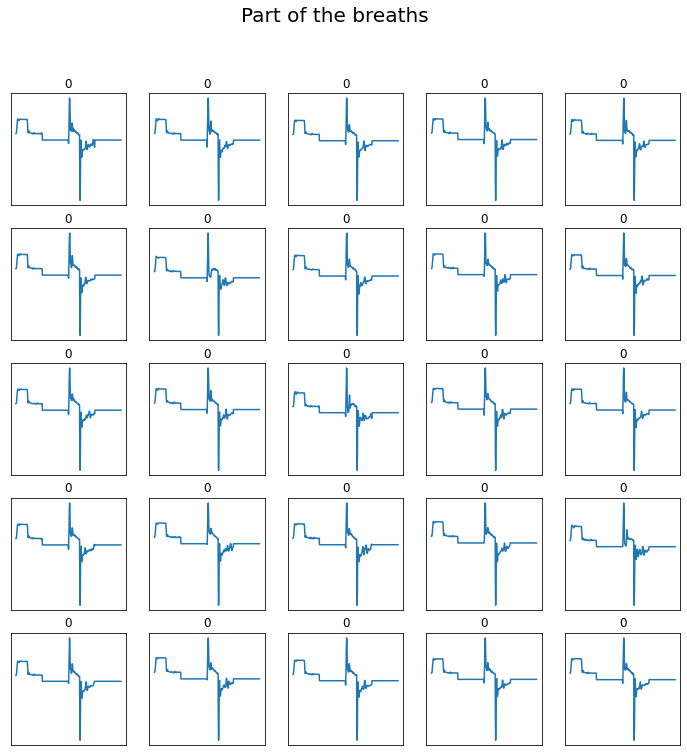

In [ ]:
def plot_segments(signals, title):
    plt.figure(figsize=(12, 12))
    col_num = 5
    row_num = 5
    signal_nums = 25
    k = 4
    for i in range(signal_nums):
        plt.subplot(row_num, col_num, i+1)
        plt.plot(signals[i + k*signal_nums]) # pay attention to the range
        plt.title(anns[i + k*signal_nums])
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(title, size=20) 
    plt.show()

#check part of the hearbeats
plot_segments(signals, 'Part of the breaths')

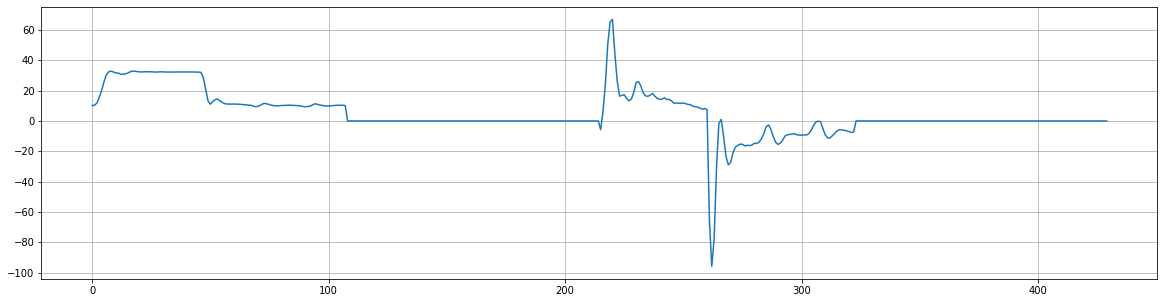

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(signals[2])
plt.grid(True)
plt.show()

In [ ]:
df = pd.read_csv("pattern.csv", skiprows=[0], header=None)
X = np.array(df[list(range(len_cut*2))].values)[..., np.newaxis]
y = np.array(df[len_cut*2].values).astype(np.int8)
#separate the datasets into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
0,10.24,10.39,11.84,15.50,20.06,25.92,30.96,32.85,33.18,32.70,32.17,30.98,30.30,30.26,30.77,31.92,33.42,33.76,33.47,32.90,32.49,32.17,32.16,32.23,32.33,32.31,32.25,32.27,32.21,32.24,32.17,32.23,32.22,32.23,32.24,32.28,32.20,32.22,32.24,32.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.90,10.07,11.67,15.58,20.27,26.66,31.85,33.06,32.93,32.11,31.39,30.80,30.04,30.48,31.45,32.74,33.50,33.72,33.20,32.64,32.12,32.13,32.30,32.39,32.47,32.29,32.24,32.18,32.17,32.19,32.15,32.14,32.19,32.27,32.29,32.29,32.24,32.25,32.29,32.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.19,10.37,11.80,15.59,20.14,25.88,30.47,32.45,32.80,32.29,31.68,31.57,30.90,30.71,31.03,31.51,32.38,32.80,32.80,32.56,32.34,32.31,32.43,32.44,32.42,32.34,32.23,32.24,32.35,32.41,32.31,32.30,32.20,32.22,32.22,32.27,32.25,32.27,32.31,32.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.16,10.32,11.77,15.58,20.26,26.29,30.69,32.41,32.86,32.32,31.50,30.88,30.65,30.83,31.54,32.46,32.93,32.73,32.58,32.28,32.13,32.17,32.35,32.48,32.47,32.38,32.27,32.18,32.13,32.33,32.37,32.32,32.37,32.30,32.24,32.18,32.19,32.32,32.29,32.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.10,10.26,11.77,15.51,20.22,26.08,30.82,32.64,32.99,32.49,31.86,31.03,30.87,30.64,30.96,31.79,32.84,33.13,33.05,32.73,32.41,32.34,32.40,32.47,32.37,32.22,32.20,32.16,32.25,32.25,32.31,32.31,32.33,32.29,32.35,32.24,32.22,32.17,32.26,32.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_1D_CNN_model():
    nclass = 6
    inp = Input(shape=(len_cut*2, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_patterns")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #model.summary()
    return model

model = get_1D_CNN_model()

In [ ]:
def get_1D_CNN_stack():
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', padding="valid", input_shape=(430, 1)))
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='valid'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='valid'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='valid'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='valid'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.2))

    model.add(Dense(units=64, activation='relu', name='dense_1'))
    model.add(Dense(units=64, activation='relu', name='dense-2'))
    model.add(Dense(6, activation='softmax', name='dense_3_patterns'))

    model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_1D_CNN_stack()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 426, 16)           96        
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 422, 16)           1296      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 211, 16)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 211, 16)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 209, 32)           1568      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 207, 32)           3104      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 103, 32)          

In [ ]:
file_path = "breaths_classification.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat] 

multi_step_history = model.fit(X_train, y_train, epochs=30, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.save("breaths_model.h5") 
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)
print("Test accuracy score : %s "% acc)

Train on 6122 samples, validate on 681 samples
Epoch 1/30
 - 3s - loss: 0.8724 - acc: 0.6787 - val_loss: 1.3581 - val_acc: 0.2775

Epoch 00001: val_acc improved from -inf to 0.27753, saving model to breaths_classification.h5
Epoch 2/30
 - 2s - loss: 0.7241 - acc: 0.7225 - val_loss: 0.7720 - val_acc: 0.7562

Epoch 00002: val_acc improved from 0.27753 to 0.75624, saving model to breaths_classification.h5
Epoch 3/30
 - 2s - loss: 0.6364 - acc: 0.7708 - val_loss: 0.5819 - val_acc: 0.7783

Epoch 00003: val_acc improved from 0.75624 to 0.77827, saving model to breaths_classification.h5
Epoch 4/30
 - 2s - loss: 0.5948 - acc: 0.7813 - val_loss: 0.5933 - val_acc: 0.7988

Epoch 00004: val_acc improved from 0.77827 to 0.79883, saving model to breaths_classification.h5
Epoch 5/30
 - 2s - loss: 0.5500 - acc: 0.8022 - val_loss: 0.5520 - val_acc: 0.7885

Epoch 00005: val_acc did not improve from 0.79883
Epoch 6/30
 - 2s - loss: 0.5142 - acc: 0.8123 - val_loss: 0.4800 - val_acc: 0.8326

Epoch 00006: v

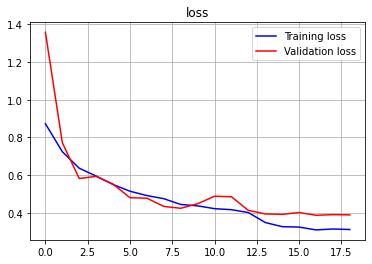

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.grid(True)
  plt.title(title)
  plt.legend()
  plt.show()
  # plt.savefig('loss.png', dpi=fig.dpi)



plot_train_history(multi_step_history, "loss")

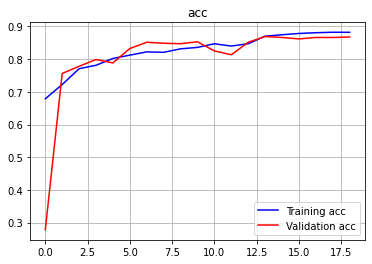

In [ ]:
def plot_train_history1(history, title):
  loss = history.history['acc']
  val_loss = history.history['val_acc']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training acc')
  plt.plot(epochs, val_loss, 'r', label='Validation acc')
  plt.grid(True)
  plt.title(title)
  plt.legend()
  plt.show()
  # plt.savefig('loss.png', dpi=fig.dpi)
plot_train_history1(multi_step_history, "acc")